In [1]:
import dnnlib
import legacy
import torch
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.interpolate
import math
import random
import preprocessing.image_utils as itools
import cv2
import synthesis.synthesis as synth
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
network_pkl = "../t-golden-fid14.19.pkl"
device = torch.device('cuda')
G = synth.load_generator(network_pkl, device)

Loading networks from "../t-golden-fid14.19.pkl"...
Network loaded.


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
torch.Size([1, 3, 1024, 1024])


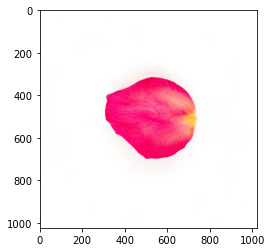

In [3]:
img = synth.synthesize_rand_image(50, G, device)
plt.imshow(img)

In [ ]:
def explore_latent():
    v = np.random.RandomState(50).randn(1, G.z_dim)
    z = torch.from_numpy(v).to(device)
    z2 = torch.from_numpy(v - 0.05).to(device)
    i1 = synth.synthesize_image(z, G, device)
    i2 = synth.synthesize_image(z2, G, device)
    return [i1, i2]
imgs = explore_latent()
synth.show_imgs(imgs)

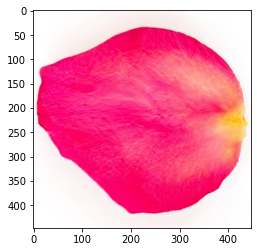

In [4]:
cropped = synth.crop_to_smallest_bbox(img)
plt.imshow(cropped)

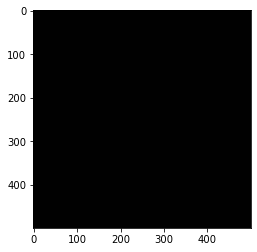

In [148]:
box = np.zeros((500, 500, 3), dtype='uint8')
# box = np.pad(box, pad_width=((100, 100), (100, 100), (0,0)), mode='constant', constant_values=255)
plt.imshow(box)

img.shape (500, 500, 3) uint8
skewed.shape (500, 250, 3)
end_height 250.0
out shape (500, 250, 3) uint8


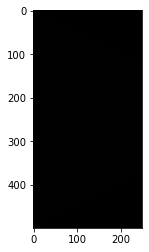

In [154]:
def transform_perspective(img, stride = 1, dw = 0.5, dh = 0.5):
    print("img.shape", img.shape, img.dtype)
    height, width, _ = img.shape
#     theta = theta * math.pi / 180 
    
    # first need to resize horizontally so that we don't have abnormal
    # elongation of "distant" pixels
#     w = math.cos(theta) * width
#     pil = PIL.Image.fromarray(img, 'RGB')
#     img = np.array(pil.resize((round(w), height), resample=PIL.Image.BICUBIC))
#     print("skewed.shape", img.shape)
#     _h, _w, _ = img.shape

    vw = width * dw
    vh = height * dh
#     w1 = (height - vh) / (2 * math.sin(theta))
    pil = PIL.Image.fromarray(img, 'RGB')
    img = np.array(pil.resize((round(vw), height), resample=PIL.Image.BICUBIC))
    print("skewed.shape", img.shape)
    _h, _w, _ = img.shape
    
    print("end_height", vh)
    out = np.zeros(img.shape, dtype='uint8')
    vd = height - vh
    for i in range(0, _w, stride):
        r = img[:, i:i+stride, :] # get the slice
        # h = height - 2 * width * math.sin(theta) * i
        # print("h", h)
        h = height - (i / (_w - 1)) * (height - vh)
#         print(h)
        #h = height - math.tan(theta) * i # perspective height of the slice
        pil = PIL.Image.fromarray(r, 'RGB') # resize
        r = np.array(pil.resize((r.shape[1], round(h)), resample=PIL.Image.BICUBIC))
        
        # pad the slice to get the same height as before
        diff = (height - r.shape[0])
        pad = diff // 2
        xtra = 0 if not diff % 2 else 1
        npad = ((pad, pad+xtra), (0, 0), (0, 0))
        b = np.pad(r, pad_width=npad, mode='constant', constant_values=0)
        
        # apply to the new shape
        out[:, i:i+stride, :] = b
    
    print("out shape", out.shape, out.dtype)
    return out

# def transform_perspective(img, stride = 1, vw = 1, vh = 1):
    

r = transform_perspective(box)
plt.imshow(r)

In [165]:
num_seeds = 2
seeds = [random.randint(1, 10000) for _ in range(num_seeds)]
imgs = synth.synthesize_rand_interp(seeds, G, device, 10)  
imgs = imgs[:10]

interpolating:  [3390, 6265]
ws.shape original torch.Size([2, 16, 512])
ws[:1].shape torch.Size([2])
ws.shape torch.Size([1, 1, 2, 16, 512])
x.shape, y.shape (6,) (6, 16, 512)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.76it/s]


In [166]:
def crop_and_normalize(imgs):
    # crop to bbox
    cropped_imgs = []
    for img in imgs:
        cropped = synth.crop_to_smallest_bbox(img)
        cropped_imgs.append(cropped)
    size = None
    for img in cropped_imgs:
        if size is None or img.shape[0] < size:
            size = img.shape[0]
    resized_imgs = []
    for img in cropped_imgs:
        pil = PIL.Image.fromarray(img, 'RGB')
        resized = pil.resize((size, size), resample=PIL.Image.BICUBIC)
        resized_imgs.append(np.array(resized))
    return resized_imgs

resized = crop_and_normalize(imgs)

out.shape (366, 3660, 3) 10
(366, 3660, 3)


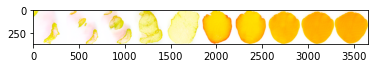

In [167]:
def stitch(imgs, mode='horizontal'):
    height, width, _ = imgs[0].shape
    shape = (height, width * len(imgs), 3)
    if mode == 'vertical':
        shape = (height * len(imgs), width, 3)
    out = np.zeros(shape, dtype='uint8')
    print("out.shape", out.shape, len(imgs))
    for i in range(len(imgs)):
        if mode == 'vertical':
            s = i * height
            out[s:s+height, :, :] = imgs[i]
        else:
            s = i * width
            out[:, s:s+width, :] = imgs[i]
    print(out.shape)
    return out
large = stitch(resized)
plt.imshow(large)

out.shape (7605, 7605, 3)


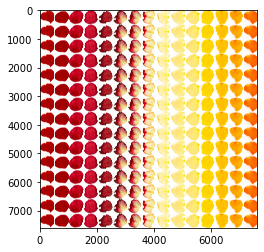

In [55]:
def stack(img, mode='n', n=10):
    height, width, _ = img.shape
    if mode == 'square':
        n = width // height
    out = np.zeros((n*height, width, 3), dtype='uint8')
    print("out.shape", out.shape)
    for i in range(n):
        h = i*height
        out[h:h+height, :, :] = img
    return out
stacked = stack(large, mode='square')
plt.imshow(stacked)

img.shape (7605, 7605, 3) uint8
skewed.shape (7605, 3802, 3)
end_height 3802.5
out shape (7605, 3802, 3) uint8


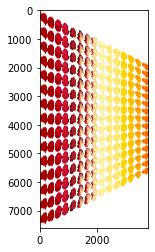

In [123]:
wall = transform_perspective(stacked)
plt.imshow(wall)

img.shape (7605, 7605, 3) uint8
skewed.shape (7605, 1901, 3)
end_height 3802.5
out shape (7605, 1901, 3) uint8
left.shape (7605, 1901, 3)
right.shape (7605, 1901, 3)
bottom.shape (1901, 7605, 3)
top.shape (1901, 7605, 3)


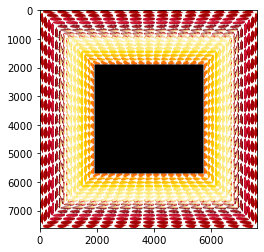

In [155]:
def create_hallway(imgs):
    left = transform_perspective(imgs, dw = 0.25, dh = 0.5)
    right = np.copy(left[...,::-1,:])
    bottom = np.rot90(left)
    top = np.rot90(right)
    print("left.shape", left.shape)
    print("right.shape", right.shape)
    print("bottom.shape", bottom.shape)
    print("top.shape", top.shape)
    out = np.zeros((left.shape[0], bottom.shape[1], 3), dtype='uint8')
    out[:, :left.shape[1], :] += left
    out[:, -right.shape[1]:, :] += right
    out[:top.shape[0], :, :] += top
    out[-bottom.shape[0]:, :, :] += bottom
    return out
hallways = create_hallway(stacked)
plt.imshow(hallways)

interpolating:  [4325, 5744]
ws.shape original torch.Size([2, 16, 512])
ws[:1].shape torch.Size([2])
ws.shape torch.Size([1, 1, 2, 16, 512])
x.shape, y.shape (6,) (6, 16, 512)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


out.shape (339, 3390, 3) 10
(339, 3390, 3)
out.shape (3390, 3390, 3)
img.shape (3390, 3390, 3) uint8
skewed.shape (3390, 848, 3)
end_height 1695.0
out shape (3390, 848, 3) uint8
left.shape (3390, 848, 3)
right.shape (3390, 848, 3)
bottom.shape (848, 3390, 3)
top.shape (848, 3390, 3)


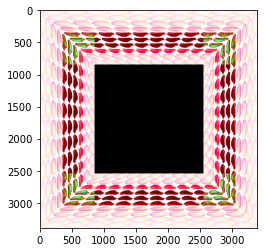

In [153]:
def synthesize_hallway():
    num_seeds = 2
    seeds = [random.randint(1, 10000) for _ in range(num_seeds)]
    imgs = synth.synthesize_rand_interp(seeds, G, device, 5)
    imgs = crop_and_normalize(imgs)
    imgs = stitch(imgs)
    imgs = stack(imgs, mode='square')
    hallway = create_hallway(imgs)
    return hallway
plt.imshow(synthesize_hallway())  